In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Transform: Normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
# Load MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 61.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.62MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.80MB/s]


In [ ]:
# Add noise to images
def add_noise(inputs, noise_factor=0.5):
    noisy = inputs + noise_factor * torch.randn_like(inputs)
    return torch.clamp(noisy, 0., 1.)

In [ ]:
# Define Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self): # Changed _init_ to __init__
        super(DenoisingAutoencoder, self).__init__()
        # Define your layers here
        # Example:
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # For reconstruction, sigmoid is often used
        )
    def forward(self, x):
        # Include your code here
        x = x.view(-1, 28*28)  # Flatten the input image
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)  # Reshape to image dimensions
        return x

In [ ]:
#Initialize model, loss function and optimizer
model = DenoisingAutoencoder().to(device)
summary(model, (1, 28, 28))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 12]             780
              ReLU-6                   [-1, 12]               0
            Linear-7                    [-1, 3]              39
            Linear-8                   [-1, 12]              48
              ReLU-9                   [-1, 12]               0
           Linear-10                   [-1, 64]             832
             ReLU-11                   [-1, 64]               0
           Linear-12                  [-1, 128]           8,320
             ReLU-13                  [-1, 128]               0
           Linear-14                  [

In [ ]:
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 12]             780
              ReLU-6                   [-1, 12]               0
            Linear-7                    [-1, 3]              39
            Linear-8                   [-1, 12]              48
              ReLU-9                   [-1, 12]               0
           Linear-10                   [-1, 64]             832
             ReLU-11                   [-1, 64]               0
           Linear-12                  [-1, 128]           8,320
             ReLU-13                  [-1, 128]               0
           Linear-14                  [

In [ ]:
# Train the autoencoder
def train(model, loader, criterion, optimizer, epochs=5):
    # Include your code here
    model.train() # Set the model to training mode
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(loader):
            data = data.to(device)
            noisy_data = add_noise(data)  # Add noise to the input data
            optimizer.zero_grad()
            output = model(noisy_data)
            loss = criterion(output, data)  # Calculate loss
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(loader)}], Loss: {loss.item():.4f}')

In [ ]:

# Evaluate and visualize
def visualize_denoising(model, loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            noisy_images = add_noise(images).to(device)
            outputs = model(noisy_images)
            break

    images = images.cpu().numpy()
    noisy_images = noisy_images.cpu().numpy()
    outputs = outputs.cpu().numpy()

    print("Name: NITHIYANERANJAN S                ")
    print("Register Number: 212223040136             ")
    plt.figure(figsize=(18, 6))
    for i in range(num_images):
        # Original
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title("Original")
        plt.axis("off")

        # Noisy
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(noisy_images[i].squeeze(), cmap='gray')
        ax.set_title("Noisy")
        plt.axis("off")

        # Denoised
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(outputs[i].squeeze(), cmap='gray')
        ax.set_title("Denoised")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Epoch [1/5], Step [1/469], Loss: 0.2313
Epoch [1/5], Step [101/469], Loss: 0.0693
Epoch [1/5], Step [201/469], Loss: 0.0675
Epoch [1/5], Step [301/469], Loss: 0.0613
Epoch [1/5], Step [401/469], Loss: 0.0605
Epoch [2/5], Step [1/469], Loss: 0.0577
Epoch [2/5], Step [101/469], Loss: 0.0583
Epoch [2/5], Step [201/469], Loss: 0.0564
Epoch [2/5], Step [301/469], Loss: 0.0563
Epoch [2/5], Step [401/469], Loss: 0.0563
Epoch [3/5], Step [1/469], Loss: 0.0577
Epoch [3/5], Step [101/469], Loss: 0.0537
Epoch [3/5], Step [201/469], Loss: 0.0574
Epoch [3/5], Step [301/469], Loss: 0.0565
Epoch [3/5], Step [401/469], Loss: 0.0565
Epoch [4/5], Step [1/469], Loss: 0.0537
Epoch [4/5], Step [101/469], Loss: 0.0591
Epoch [4/5], Step [201/469], Loss: 0.0568
Epoch [4/5], Step [301/469], Loss: 0.0516
Epoch [4/5], Step [401/469], Loss: 0.0534
Epoch [5/5], Step [1/469], Loss: 0.0540
Epoch [5/5], Step [101/469], Loss: 0.0538
Epoch [5/5], Step [201/469], Loss: 0.0555
Epoch [5/5], Step [301/469], Loss: 0.0512
Ep

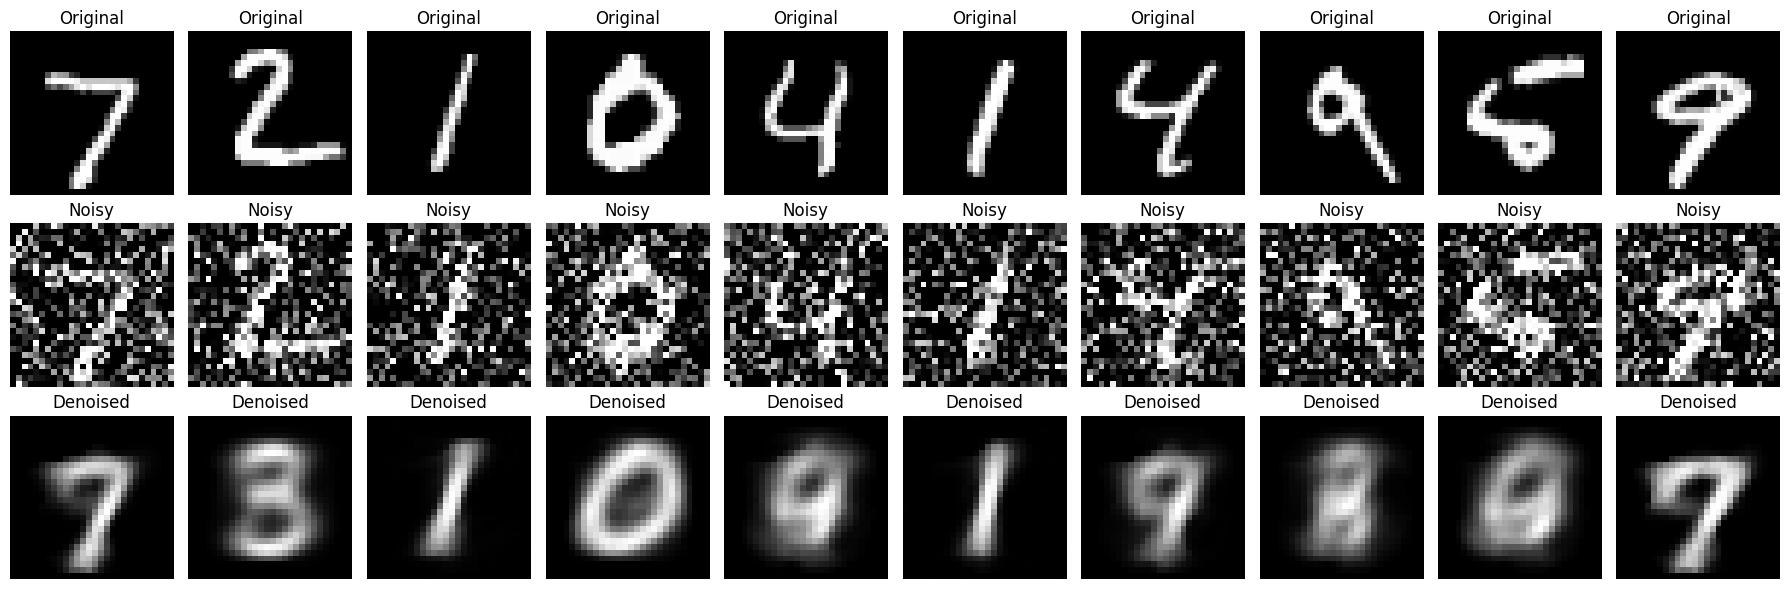

In [ ]:
# Run training and visualization
train(model, train_loader, criterion, optimizer, epochs=5)
visualize_denoising(model, test_loader)